<a href="https://colab.research.google.com/github/catchyla99/Zeru-V2/blob/main/Processing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import QuantileTransformer, StandardScaler
import networkx as nx
from sklearn.cluster import KMeans

df = pd.read_csv('/content/drive/MyDrive/ZERU/compoundV2_all_transactions_cleaned.csv', parse_dates=['timestamp'])

if 'action' not in df.columns:
    df['action'] = 'deposit'

df = df.sort_values(by=['wallet', 'timestamp'])
df['prev_time'] = df.groupby('wallet')['timestamp'].shift()
df['gap'] = (df['timestamp'] - df['prev_time']).dt.total_seconds().fillna(0)
df['new_session'] = df['gap'] > 3600
df['session_id'] = df.groupby('wallet')['new_session'].cumsum()

wallets = df.groupby('wallet').agg(
    tx_count=('hash', 'count'),
    unique_assets=('asset_symbol', 'nunique'),
    total_amountUSD=('amountUSD', 'sum'),
    avg_amountUSD=('amountUSD', 'mean'),
    activity_span=('timestamp', lambda x: (x.max() - x.min()).days + 1),
    active_days=('timestamp', lambda x: x.dt.date.nunique()),
    std_gap=('gap', 'std'),
    session_count=('session_id', 'nunique'),
).copy()

cutoff = df['timestamp'].max() - pd.Timedelta(days=30)
recent = df[df['timestamp'] >= cutoff].groupby('wallet')['hash'].count()
wallets['recent_tx_ratio'] = recent / wallets['tx_count']
wallets['recent_tx_ratio'] = wallets['recent_tx_ratio'].fillna(0)

flash_like_score = df[df['gap'] < 30].groupby('wallet')['amountUSD'].sum()
wallets['flash_like_score'] = flash_like_score
wallets['flash_like_score'] = wallets['flash_like_score'].fillna(0)

edges = df[['wallet', 'asset_symbol']].drop_duplicates()
B = nx.Graph()
B.add_nodes_from(edges['wallet'], bipartite=0)
B.add_nodes_from(edges['asset_symbol'], bipartite=1)
B.add_edges_from([tuple(x) for x in edges.to_numpy()])
centrality = nx.degree_centrality(B)
wallets['graph_centrality'] = wallets.index.map(lambda x: centrality.get(x, 0))

for act in ['deposit', 'borrow', 'repay', 'withdraw', 'liquidation']:
    if act in df['action'].unique():
        wallets[f'num_{act}'] = df[df['action'] == act].groupby('wallet')['action'].count()
    else:
        wallets[f'num_{act}'] = 0

clustering_data = wallets[['tx_count', 'total_amountUSD', 'unique_assets']].fillna(0)
scaler = QuantileTransformer(output_distribution='uniform')
clustering_scaled = scaler.fit_transform(clustering_data)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10).fit(clustering_scaled)
wallets['cluster_label'] = kmeans.labels_

score_data = wallets.copy()
score_features = [
    'tx_count', 'total_amountUSD', 'unique_assets', 'avg_amountUSD',
    'active_days', 'graph_centrality', 'recent_tx_ratio', 'session_count'
]
scaler2 = StandardScaler()
score_data[score_features] = scaler2.fit_transform(score_data[score_features])
score_data['flash_penalty'] = np.log1p(score_data['flash_like_score'])

score_data['score_raw'] = (
    0.18 * score_data['tx_count'] +
    0.18 * score_data['total_amountUSD'] +
    0.10 * score_data['unique_assets'] +
    0.10 * score_data['avg_amountUSD'] +
    0.10 * score_data['active_days'] +
    0.10 * score_data['graph_centrality'] +
    0.10 * score_data['recent_tx_ratio'] +
    0.10 * score_data['session_count'] -
    0.06 * score_data['flash_penalty']
)

score_data['score'] = 1 / (1 + np.exp(-score_data['score_raw']))
score_data['score'] = (score_data['score'] - score_data['score'].min()) / (score_data['score'].max() - score_data['score'].min()) * 100

final_cols = [
    'wallet', 'score', 'cluster_label', 'tx_count', 'unique_assets', 'total_amountUSD',
    'avg_amountUSD', 'active_days', 'session_count', 'recent_tx_ratio',
    'flash_like_score', 'graph_centrality', 'num_deposit', 'num_borrow', 'num_repay', 'num_withdraw', 'num_liquidation'
]
final = score_data.reset_index()[final_cols].sort_values(by='score', ascending=False).head(1000)
final.to_csv('/content/drive/MyDrive/ZERU/top_1000_wallets_full.csv', index=False)

print("✅ Final CSV with all key features saved as 'top_1000_wallets_full.csv'.")

print("\nTop 5 wallets (for analysis):")
print(final.head())
print("\nBottom 5 wallets (for analysis):")
print(final.tail())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Final CSV with all key features saved as 'top_1000_wallets_full.csv'.

Top 5 wallets (for analysis):
                                            wallet  score  cluster_label  \
148269  0x619ad2d02dbee6eba3cdbda3f98430410e892882  100.0              2   
337987  0xde9ec95d7708b8319ccca4b8bc92c0a3b70bf416  100.0              2   
356691  0xeb21209ae4c2c9ff2a86aca31e123764a3b6bc06  100.0              1   
358039  0xebfb47a7ad0fd6e57323c8a42b2e5a6a4f68fc1a  100.0              2   
159775  0x691d4172331a11912c6d0e6d1a002e3d7ced6a66  100.0              2   

          tx_count  unique_assets  total_amountUSD  avg_amountUSD  \
148269    1.421873      -0.334860       377.252709     264.452498   
337987  113.562989      -0.334860         3.323018       0.005063   
356691  150.846539       1.016245        19.788779       0.110268   
358039  199.811022      -0.334860  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.cluster import KMeans
import networkx as nx

df = pd.read_csv('/content/drive/MyDrive/ZERU/compoundV2_all_transactions_cleaned.csv', parse_dates=['timestamp'])

if 'action' not in df.columns:
    df['action'] = 'deposit'

df = df.sort_values(by=['wallet', 'timestamp'])
df['prev_time'] = df.groupby('wallet')['timestamp'].shift()
df['gap'] = (df['timestamp'] - df['prev_time']).dt.total_seconds().fillna(0)
df['new_session'] = df['gap'] > 3600
df['session_id'] = df.groupby('wallet')['new_session'].cumsum()

wallets = df.groupby('wallet').agg(
    tx_count=('hash', 'count'),
    unique_assets=('asset_symbol', 'nunique'),
    total_amountUSD=('amountUSD', 'sum'),
    avg_amountUSD=('amountUSD', 'mean'),
    std_amountUSD=('amountUSD', 'std'),
    activity_span=('timestamp', lambda x: (x.max() - x.min()).days + 1),
    active_days=('timestamp', lambda x: x.dt.date.nunique()),
    std_gap=('gap', 'std'),
    session_count=('session_id', 'nunique'),
).copy()

cutoff = df['timestamp'].max() - pd.Timedelta(days=30)
recent = df[df['timestamp'] >= cutoff].groupby('wallet')['hash'].count()
wallets['recent_tx_ratio'] = recent / wallets['tx_count']
wallets['recent_tx_ratio'] = wallets['recent_tx_ratio'].fillna(0)

flash_like_score = df[df['gap'] < 30].groupby('wallet')['amountUSD'].sum()
wallets['flash_like_score'] = flash_like_score.reindex(wallets.index).fillna(0)

edges = df[['wallet', 'asset_symbol']].drop_duplicates()
B = nx.Graph()
B.add_nodes_from(edges['wallet'], bipartite=0)
B.add_nodes_from(edges['asset_symbol'], bipartite=1)
B.add_edges_from([tuple(x) for x in edges.to_numpy()])
centrality = nx.degree_centrality(B)
wallets['graph_centrality'] = wallets.index.map(lambda x: centrality.get(x, 0))

wallet_asset_pairs = df[['wallet', 'asset_symbol']].drop_duplicates()
wallet_graph = nx.Graph()
wallet_graph.add_edges_from(wallet_asset_pairs.to_records(index=False))
try:
    wallets['clique_score'] = wallets.index.map(lambda w: len(list(nx.cliques_containing_node(wallet_graph, w))) if w in wallet_graph else 0)
except Exception:
    wallets['clique_score'] = 0

for act in ['deposit', 'borrow', 'repay', 'withdraw', 'liquidation']:
    wallets[f'num_{act}'] = df[df['action'] == act].groupby('wallet')['action'].count().reindex(wallets.index).fillna(0)

tx_per_session = df.groupby(['wallet', 'session_id'])['hash'].count().reset_index()
burst = tx_per_session.groupby('wallet')['hash'].agg(['mean', 'std']).rename(columns={'mean': 'mean_tx_session', 'std': 'std_tx_session'})
wallets = wallets.join(burst, how='left').fillna(0)

df['days_since'] = (df['timestamp'].max() - df['timestamp']).dt.days
df['decay_weight'] = np.exp(-df['days_since'] / 30)
time_decay_score = df.groupby('wallet')['decay_weight'].sum()
wallets['time_decay_score'] = time_decay_score.reindex(wallets.index).fillna(0)

behavior_features = wallets[['std_gap', 'unique_assets', 'session_count', 'active_days']].fillna(0)
behavior_scaled = QuantileTransformer(output_distribution='normal').fit_transform(behavior_features)
wallets['behavior_cluster'] = KMeans(n_clusters=4, random_state=1, n_init=10).fit_predict(behavior_scaled)

wallets['flag_suspicious'] = ((wallets['flash_like_score'] > 1e6) | (wallets['num_liquidation'] > 5)).astype(int)

def profile(row):
    if row['total_amountUSD'] > 1e6:
        return 'Whale'
    if row['num_borrow'] > 20:
        return 'Active Borrower'
    if row['num_liquidation'] > 3:
        return 'High Risk'
    if row['recent_tx_ratio'] > 0.8:
        return 'Very Active'
    return 'Normal'
wallets['profile_tag'] = wallets.apply(profile, axis=1)

score_features = [
    'tx_count', 'total_amountUSD', 'unique_assets', 'avg_amountUSD',
    'active_days', 'graph_centrality', 'recent_tx_ratio', 'session_count',
    'mean_tx_session', 'std_tx_session', 'time_decay_score', 'clique_score'
]
scaler = StandardScaler()
wallets[score_features] = scaler.fit_transform(wallets[score_features].fillna(0))
wallets['flash_penalty'] = np.log1p(wallets['flash_like_score'])

wallets['score_raw'] = (
    0.15 * wallets['tx_count'] +
    0.15 * wallets['total_amountUSD'] +
    0.10 * wallets['unique_assets'] +
    0.10 * wallets['avg_amountUSD'] +
    0.10 * wallets['active_days'] +
    0.10 * wallets['graph_centrality'] +
    0.05 * wallets['recent_tx_ratio'] +
    0.05 * wallets['session_count'] +
    0.05 * wallets['mean_tx_session'] +
    0.05 * wallets['time_decay_score'] +
    0.05 * wallets['clique_score'] -
    0.05 * wallets['flash_penalty']
)
wallets['score'] = 1 / (1 + np.exp(-wallets['score_raw']))
wallets['score'] = (wallets['score'] - wallets['score'].min()) / (wallets['score'].max() - wallets['score'].min()) * 100

final_cols = [
    'score', 'tx_count', 'unique_assets', 'total_amountUSD', 'avg_amountUSD',
    'std_amountUSD', 'active_days', 'session_count', 'recent_tx_ratio',
    'flash_like_score', 'graph_centrality', 'clique_score',
    'num_deposit', 'num_borrow', 'num_repay', 'num_withdraw', 'num_liquidation',
    'mean_tx_session', 'std_tx_session', 'time_decay_score',
    'behavior_cluster', 'flag_suspicious', 'profile_tag'
]
final = wallets.reset_index()[['wallet'] + final_cols].sort_values(by='score', ascending=False).head(1000)
final.to_csv('/content/drive/MyDrive/ZERU/top_1000_wallets_full.csv', index=False)

print("✅ Final CSV with ALL advanced features and scoring saved as 'top_1000_wallets_full.csv'")
print("\nTop 5 wallets (for analysis):")
print(final.head())
print("\nBottom 5 wallets (for analysis):")
print(final.tail())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Final CSV with ALL advanced features and scoring saved as 'top_1000_wallets_full.csv'

Top 5 wallets (for analysis):
                                            wallet  score    tx_count  \
130776  0x56178a0d5f301baf6cf3e1cd53d9863437345bf9  100.0  130.991026   
159775  0x691d4172331a11912c6d0e6d1a002e3d7ced6a66  100.0    5.197948   
281716  0xb99cc7e10fe0acc68c50c7829f473d81e23249cc  100.0   82.296262   
356691  0xeb21209ae4c2c9ff2a86aca31e123764a3b6bc06  100.0  150.846539   
63785   0x29fe7d60ddf151e5b52e5fab4f1325da6b2bd958  100.0  348.571762   

        unique_assets  total_amountUSD  avg_amountUSD  std_amountUSD  \
130776       1.016245        12.355582       0.072219   2.817418e+05   
159775      -0.334860       422.798291      83.156276   6.118636e+07   
281716       9.122874        21.687215       0.246862   2.012981e+06   
356691       1.016245    

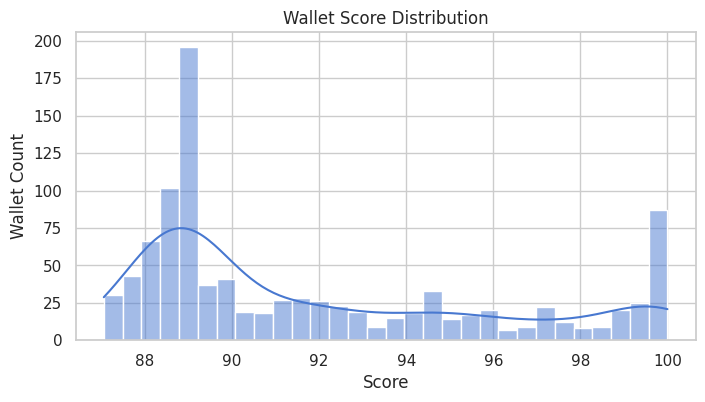

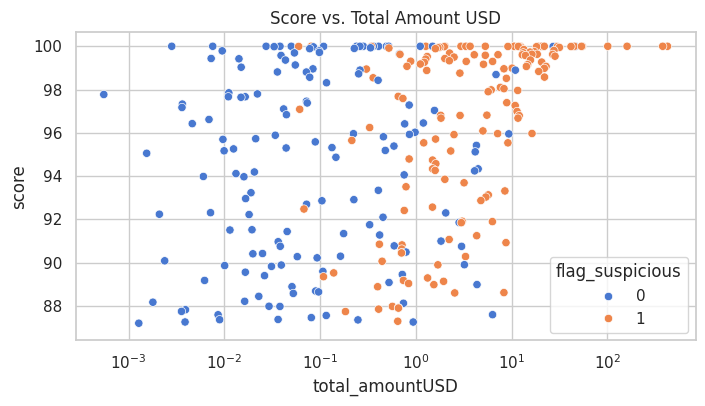

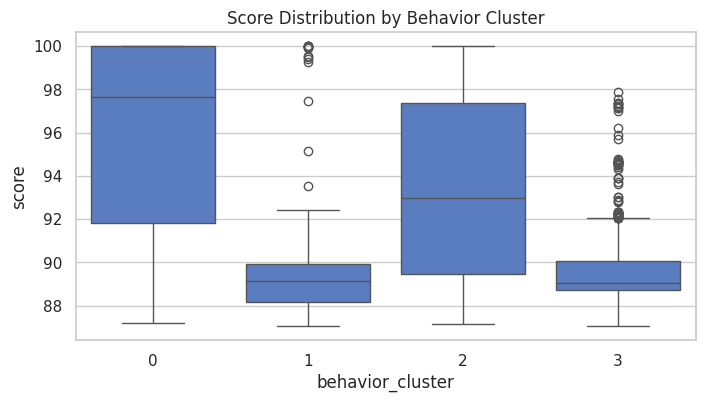

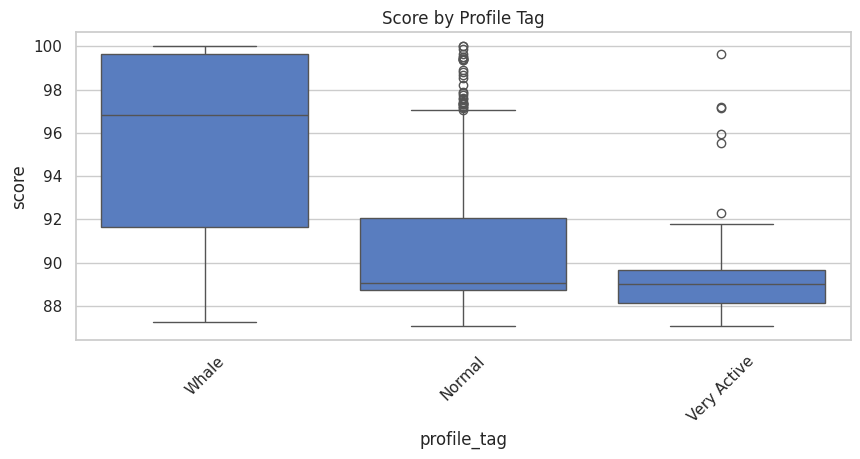

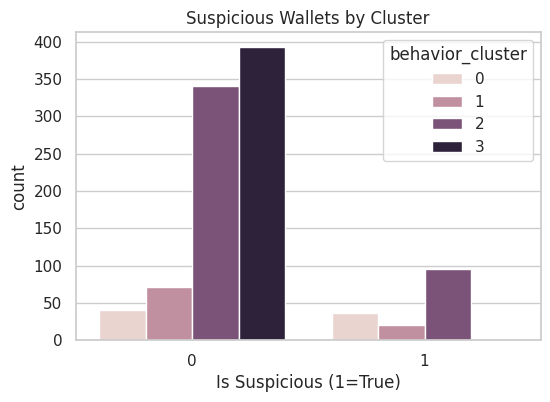

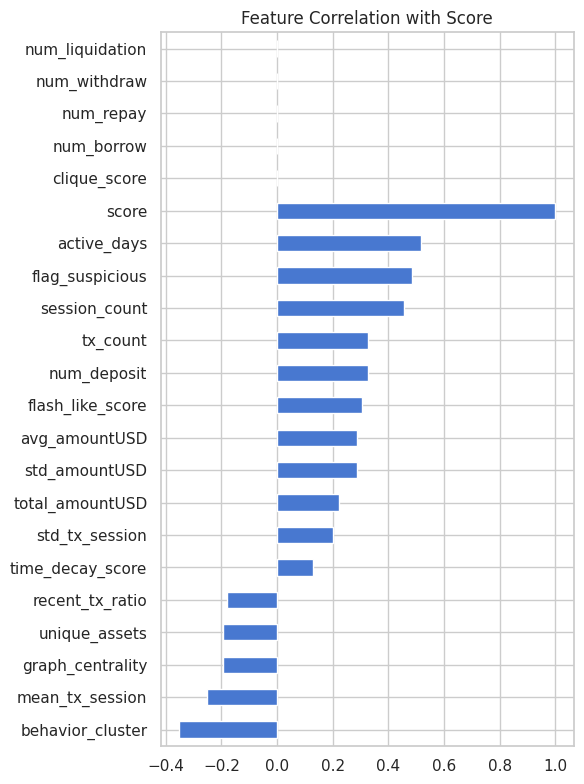

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(8, 4))
sns.histplot(final['score'], bins=30, kde=True)
plt.title('Wallet Score Distribution')
plt.xlabel('Score')
plt.ylabel('Wallet Count')
plt.show()

plt.figure(figsize=(8, 4))
sns.scatterplot(data=final, x='total_amountUSD', y='score', hue='flag_suspicious')
plt.title('Score vs. Total Amount USD')
plt.xscale('log')
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=final, x='behavior_cluster', y='score')
plt.title('Score Distribution by Behavior Cluster')
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=final, x='profile_tag', y='score')
plt.title('Score by Profile Tag')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=final, x='flag_suspicious', hue='behavior_cluster')
plt.title('Suspicious Wallets by Cluster')
plt.xlabel('Is Suspicious (1=True)')
plt.show()

plt.figure(figsize=(6, 8))
numeric_cols = final.select_dtypes(include=['number'])
numeric_cols.corr()['score'].sort_values().plot(kind='barh', title='Feature Correlation with Score')
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

wallet_sample = wallets.sample(frac=0.2, random_state=42)

X_cluster = wallet_sample[['std_gap', 'unique_assets', 'session_count', 'active_days']]

print("Silhouette Scores (on sample):")
for n_clusters in range(2, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init=10)
    clusters = kmeans.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, clusters)
    print(f'Clusters: {n_clusters}, Silhouette Score: {score:.4f}')

X = wallets[score_features]
y = wallets['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

print("\nFeature Weights:")
for feat, coef in zip(score_features, model.coef_):
    print(f"{feat}: {coef:.4f}")


Silhouette Scores (on sample):
Clusters: 2, Silhouette Score: 0.9572
Clusters: 3, Silhouette Score: 0.9434
Clusters: 4, Silhouette Score: 0.9365
Clusters: 5, Silhouette Score: 0.9345
Clusters: 6, Silhouette Score: 0.9303

Feature Weights:
tx_count: -0.3456
total_amountUSD: -0.0596
unique_assets: 3.3023
avg_amountUSD: 0.7271
active_days: 1.2424
graph_centrality: 3.3023
recent_tx_ratio: 1.3546
session_count: 0.2248
mean_tx_session: 1.1725
std_tx_session: 0.0611
time_decay_score: -0.0099
clique_score: 0.0000


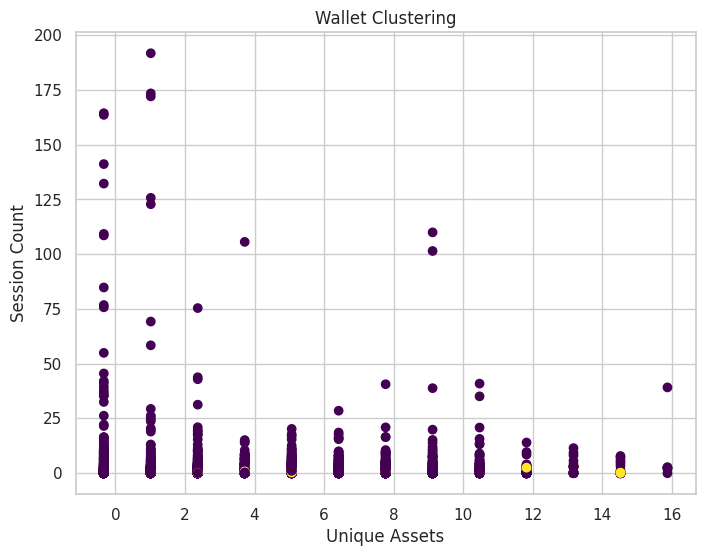

In [27]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

kmeans = KMeans(n_clusters=2, random_state=1)
wallets['cluster'] = kmeans.fit_predict(wallets[['std_gap', 'unique_assets', 'session_count', 'active_days']])

score_features = ['std_gap', 'unique_assets', 'session_count', 'active_days']
model = LinearRegression()
X = wallets[score_features]
model.fit(X, wallets['score'])

wallets['raw_score'] = model.predict(X)
wallets['score'] = MinMaxScaler().fit_transform(wallets[['raw_score']]) * 100

cluster_labels = {0: 'Reliable', 1: 'Risky'} if wallets.groupby('cluster')['score'].mean()[0] > wallets.groupby('cluster')['score'].mean()[1] else {0: 'Risky', 1: 'Reliable'}
wallets['label'] = wallets['cluster'].map(cluster_labels)

wallets.to_csv("wallets_with_scores.csv", index=False)

plt.figure(figsize=(8,6))
plt.scatter(wallets['unique_assets'], wallets['session_count'], c=wallets['cluster'], cmap='viridis')
plt.xlabel('Unique Assets')
plt.ylabel('Session Count')
plt.title('Wallet Clustering')
plt.show()


In [30]:
best_n_clusters = 4
kmeans_final = KMeans(n_clusters=best_n_clusters, random_state=1, n_init=10)
wallets['behavior_cluster'] = kmeans_final.fit_predict(wallets[['std_gap', 'unique_assets', 'session_count', 'active_days']])


In [31]:
final_cols = [
    'score', 'tx_count', 'unique_assets', 'total_amountUSD', 'avg_amountUSD',
    'std_amountUSD', 'active_days', 'session_count', 'recent_tx_ratio',
    'flash_like_score', 'graph_centrality', 'clique_score',
    'num_deposit', 'num_borrow', 'num_repay', 'num_withdraw', 'num_liquidation',
    'mean_tx_session', 'std_tx_session', 'time_decay_score',
    'behavior_cluster', 'flag_suspicious', 'profile_tag'
]
final = wallets.reset_index()[['wallet'] + final_cols].sort_values(by='score', ascending=False).head(1000)
final.to_csv('/content/drive/MyDrive/ZERU/top_1000_wallets_full.csv', index=False)
print("✅ Final CSV with all features and cluster labels saved as 'top_1000_wallets_full.csv'")


✅ Final CSV with all features and cluster labels saved as 'top_1000_wallets_full.csv'


In [32]:
top_1000 = wallets.reset_index().sort_values(by='score', ascending=False).head(1000)

cols_to_export = ['wallet', 'score']
top_1000[cols_to_export].to_csv('/content/drive/MyDrive/ZERU/top_1000_wallets.csv', index=False)

print("✅ Top 1000 wallets saved to your Google Drive as 'top_1000_wallets.csv'")


✅ Top 1000 wallets saved to your Google Drive as 'top_1000_wallets.csv'


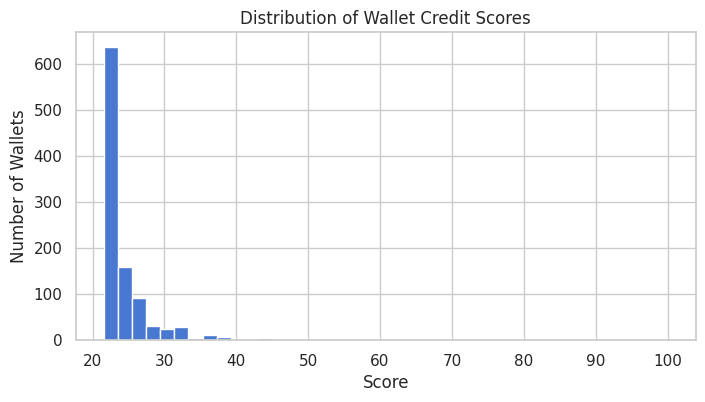

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
final['score'].hist(bins=40)
plt.title('Distribution of Wallet Credit Scores')
plt.xlabel('Score')
plt.ylabel('Number of Wallets')
plt.show()


In [35]:
final_cols = [
    'score', 'tx_count', 'unique_assets', 'total_amountUSD', 'avg_amountUSD',
    'std_amountUSD', 'active_days', 'session_count', 'recent_tx_ratio',
    'flash_like_score', 'graph_centrality', 'clique_score',
    'num_deposit', 'num_borrow', 'num_repay', 'num_withdraw', 'num_liquidation',
    'mean_tx_session', 'std_tx_session', 'time_decay_score',
    'behavior_cluster', 'flag_suspicious', 'profile_tag'
]

full_wallets = wallets.reset_index()[['wallet'] + final_cols]

full_wallets.to_csv('/content/drive/MyDrive/ZERU/all_wallets_full.csv', index=False)
print("✅ Full wallet dataset saved as 'all_wallets_full.csv'")


✅ Full wallet dataset saved as 'all_wallets_full.csv'


In [36]:
import pandas as pd

full_wallets = pd.read_csv('/content/drive/MyDrive/ZERU/all_wallets_full.csv')

top5 = full_wallets.sort_values('score', ascending=False).head(5)
bottom5 = full_wallets.sort_values('score', ascending=True).head(5)

cols = [
    'wallet', 'score', 'profile_tag', 'tx_count', 'unique_assets', 'total_amountUSD',
    'session_count', 'recent_tx_ratio', 'flash_like_score', 'graph_centrality',
    'num_borrow', 'num_liquidation', 'behavior_cluster'
]

def explain(row):
    reasons = []
    if row['score'] > 80:
        reasons.append("Very high score: likely consistent, high-volume, and diverse activity.")
    if row['score'] < 30:
        reasons.append("Low score: likely low activity, or flagged as risky/bot-like.")
    if row['profile_tag'] == 'Whale':
        reasons.append("Large total USD volume (Whale).")
    if row['profile_tag'] == 'High Risk':
        reasons.append("Multiple liquidations or flash loan activity (High Risk).")
    if row['recent_tx_ratio'] > 0.7:
        reasons.append("Very active in recent period.")
    if row['flash_like_score'] > 1e5:
        reasons.append("Possible flash loan or bot-like bursts detected.")
    if row['num_borrow'] > 10:
        reasons.append("Frequent borrowing activity.")
    if row['num_liquidation'] > 0:
        reasons.append("Has experienced liquidations.")
    if row['unique_assets'] > 3:
        reasons.append("Interacts with multiple assets (diversity).")
    if not reasons:
        reasons.append("Normal or mixed behavior.")
    return " ".join(reasons)

top5['explanation'] = top5.apply(explain, axis=1)
bottom5['explanation'] = bottom5.apply(explain, axis=1)

analysis = pd.concat([top5, bottom5], axis=0)[cols + ['explanation']]

analysis.to_csv('/content/drive/MyDrive/ZERU/wallet_analysis.csv', index=False)
print("✅ Wallet analysis CSV saved as 'wallet_analysis.csv'.")

from IPython.display import display
display(analysis)


✅ Wallet analysis CSV saved as 'wallet_analysis.csv'.


,wallet,score,profile_tag,tx_count,unique_assets,total_amountUSD,session_count,recent_tx_ratio,flash_like_score,graph_centrality,num_borrow,num_liquidation,behavior_cluster,explanation
281716,0xb99cc7e10fe0acc68c50c7829f473d81e23249cc,100.000000,Whale,82.296262,9.122874,21.687215,101.458586,0.160904,1.036284e+08,9.122874,0.0,0.0,1,"Very high score: likely consistent, high-volum..."
207544,0x8888882f8f843896699869179fb6e4f7e3b58888,51.686102,Whale,81.072150,9.122874,10.507838,109.964822,-0.022027,6.090352e+07,9.122874,0.0,0.0,1,Large total USD volume (Whale). Possible flash...
126008,0x52ea46506b9cc5ef470c5bf89f17dc28bb35d85c,44.365149,Whale,74.640374,1.016245,1.267871,125.732480,0.064408,4.718775e+06,1.016245,0.0,0.0,1,Large total USD volume (Whale). Possible flash...
356691,0xeb21209ae4c2c9ff2a86aca31e123764a3b6bc06,44.130515,Whale,150.846539,1.016245,19.788779,191.776834,-0.014896,4.517908e+08,1.016245,0.0,0.0,1,Large total USD volume (Whale). Possible flash...
239532,0x9da6ca884f24dc29b320cc9075d769909a55a544,43.739406,Whale,20.883181,2.367350,0.080781,43.782155,-0.022027,1.007981e+06,2.367350,0.0,0.0,1,Large total USD volume (Whale). Possible flash...
178355,0x755cc7f1225a2758fd7ecb81202f476752ae0708,0.000000,Normal,-0.009715,-0.334860,-0.008485,0.006158,-0.022027,3.000000e+00,-0.334860,0.0,0.0,2,"Low score: likely low activity, or flagged as ..."
342694,0xe1b47849943475a1f87d9af7ddb355f408088fc3,0.196711,Normal,-0.009715,-0.334860,-0.008486,0.006158,-0.022027,4.085650e+00,-0.334860,0.0,0.0,2,"Low score: likely low activity, or flagged as ..."
227972,0x961aee2ffc301f2e7c8dc2c73ad761385a02f279,0.345181,Normal,-0.009715,-0.334860,-0.007797,0.006158,25.908477,3.189205e+04,-0.334860,0.0,0.0,2,"Low score: likely low activity, or flagged as ..."
344612,0xe2f8780859149a6daa02f1ddcac7f9ba0376faba,0.428979,Normal,-0.009715,-0.334860,-0.008484,0.006158,-0.022027,1.063372e+02,-0.334860,0.0,0.0,2,"Low score: likely low activity, or flagged as ..."
306165,0xc9b285dada3b96787d90c7ccfc171b5ee0513201,0.685178,Normal,-0.009715,-0.334860,-0.008275,0.006158,-0.022027,6.000000e+03,-0.334860,0.0,0.0,2,"Low score: likely low activity, or flagged as ..."
